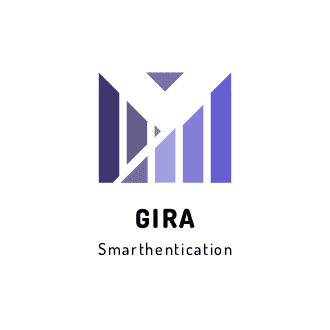

## Importando librerías y datos utilizados



In [ ]:
#Medimos tiempo de ejecución del Notebook
import time
inicio = time.time()

In [ ]:
#Cargamos librerías
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from  sklearn.decomposition import  PCA
from sklearn import preprocessing
from sklearn import tree
from sklearn.manifold import TSNE
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn import metrics
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns',None)
warnings.filterwarnings('ignore')
%matplotlib inline 


#Cambiamos formato de salida en pandas
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [ ]:
#Importamos nuestro Drive de Google
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
%cd /content/gdrive/MyDrive/Gilberto/

/content/gdrive/.shortcut-targets-by-id/1a1gS3mRNLoFPDF8B6WWNOWnfEceZ91AD/Gilberto


Link de fuente en donde se descargó la Base Train y Test de datos de giroscopio y acelerómetro 

https://www.kaggle.com/datasets/uciml/human-activity-recognition-with-smartphones?resource=download


In [ ]:
#Cargamos datos de los insumos con datos de giroscopio y acelerómetro
path = "train.csv"
train_data = pd.read_csv(path)

path_test = "test.csv"
test_data = pd.read_csv(path)

In [ ]:
#Cargamos datos de insumos BBVA
path = "INSUMO BBVA/Catalogo_giros_afil.csv"
giros_data = pd.read_csv(path)

path = "INSUMO BBVA/Clientes_Descriptivo.txt"
desc_ctes_data = pd.read_table(path, delim_whitespace= True,error_bad_lines=False)

path = "INSUMO BBVA/Transacciones_Clientes.txt"
trans_ctes_data = pd.read_table(path, delim_whitespace= True,error_bad_lines=False)

In [ ]:
giros_data.head()

,NU_AFILIACION,CD_GIRO,NB_GIRO,NB_SUBGIRO
0,7715643,5812,RESTAURANTES,"RESTAURANTES,"
1,4208483,5812,RESTAURANTES,"RESTAURANTES,"
2,4411062,5812,RESTAURANTES,"RESTAURANTES,"
3,5179627,4814,TELECOMUNICACIONES,SERVICIOS
4,4064129,5912,FARMACIAS,"DROGUERIAS,"


In [ ]:
giros_data['NB_GIRO'].value_counts()

VENTAS AL DETALLE (RETAIL)                27899
RESTAURANTES                              11370
GASOLINERAS                                8279
GRANDES SUPERFICIES                        6950
MISCELANEAS                                6122
FARMACIAS                                  5840
COMIDA RAPIDA                              5464
REFACCIONES Y FERRETERIAS                  3053
OTROS                                      2442
ENTRETENIMIENTO                            1228
HOTELES                                     963
MEDICOS Y DENTISTAS                         957
GOBIERNO                                    910
TELECOMUNICACIONES                          541
SALONES DE BELLEZA                          533
TRANSPORTE TERRESTRE DE PASAJEROS           377
PEAJE                                       352
COLEGIOS Y UNIVERSIDADES                    331
HOSPITALES                                  272
SERVICIOS VETERINARIOS                      258
EDUCACION BASICA                        

In [ ]:
#Construimos base con giros de interes (Gastos Médicos)
#GIRO: HOSPITALES FARMACIAS
#SUBGIRO: DOCTORES, OTRAS ESPECIALIDADES,(MEDICOS)
#         OPTOMETRISTAS, (OFTALMOLOGOS)

giros_medico_data=giros_data[ (giros_data['NB_GIRO'] =="HOSPITALES") | (giros_data['NB_GIRO'] =="FARMACIAS") | (giros_data['NB_SUBGIRO'] =="DOCTORES, OTRAS ESPECIALIDADES,(MEDICOS)")| (giros_data['NB_SUBGIRO'] =="OPTOMETRISTAS, (OFTALMOLOGOS)")] 

In [ ]:
giros_medico_data['NB_SUBGIRO'].value_counts()

DROGUERIAS,                                 5840
DOCTORES, OTRAS ESPECIALIDADES,(MEDICOS)     632
HOSPITALES                                   272
OPTOMETRISTAS, (OFTALMOLOGOS)                 33
Name: NB_SUBGIRO, dtype: int64

In [ ]:
desc_ctes_data.head() 

,NU_CTE_COD,EDAD,CD_ESTADO,CD_POSTAL,CD_SEXO
0,ABK0NHDA,68,DF,13360,M
1,M5JVN30B,22,JA,44760,M
2,RMMTWKSD,22,AG,20344,M
3,1VLE6Y9G,79,CH,32390,M
4,3CE1LE8Z,64,DU,34414,F


In [ ]:
desc_ctes_data.describe()

,EDAD,CD_POSTAL
count,5000.000,5000.000
mean,39.165,49991.314
std,31.388,26975.544
min,13.000,1000.000
25%,28.000,27359.750
50%,36.000,52165.500
75%,47.000,72730.000
max,2021.000,99800.000


In [ ]:
trans_ctes_data.head()

,NU_CTE_COD,FH_CORTE,FH_OPERACION,NU_AFILIACION,TIPO_TARJETA,IM_TRANSACCION
0,0MNXBHXN,01/07/2022,12/07/2022,4149168,CREDITO,495.000
1,562NS6XR,01/08/2022,03/08/2022,7476840,CREDITO,294.000
2,LYS00B64,01/04/2022,13/04/2022,8427123,DEBITO,570.000
3,YD17U634,01/05/2022,14/05/2022,6356919,DEBITO,301.000
4,M8V2EQUE,01/04/2022,22/04/2022,7979128,DEBITO,393.650


In [ ]:
#Realizamos INNER join de la tabla de transacciones con la de catalogo de giros de interés
transgiro_data=pd.merge(trans_ctes_data,giros_medico_data[["NU_AFILIACION","NB_SUBGIRO"]],on='NU_AFILIACION')

In [ ]:
transgiro_data.head()

,NU_CTE_COD,FH_CORTE,FH_OPERACION,NU_AFILIACION,TIPO_TARJETA,IM_TRANSACCION,NB_SUBGIRO
0,MBZ8VLRA,01/06/2022,30/06/2022,5738364,DEBITO,410.000,"DROGUERIAS,"
1,M94EXWWS,01/06/2022,24/06/2022,1046359,DEBITO,475.000,"DROGUERIAS,"
2,0JFPDN4M,01/07/2022,20/07/2022,9454042,CREDITO,1313.500,"DROGUERIAS,"
3,GNJYGV90,01/09/2022,17/09/2022,9454042,CREDITO,763.000,"DROGUERIAS,"
4,MWL8AR0G,01/05/2022,15/05/2022,9454042,DEBITO,330.500,"DROGUERIAS,"


In [ ]:
transgiro_data['NU_CTE_COD'].value_counts()

D0T2LSVU    201
BQYAP67G    121
ACU0FPQJ     81
2VK430TY     78
A0S9LVE9     66
           ... 
TRL3JQ23      1
Y6HG0KDS      1
VYGCXR8Y      1
A6NPZLQS      1
D0BMXP4V      1
Name: NU_CTE_COD, Length: 3243, dtype: int64

Uno de los criterios en la construcción del Buyer Person, es obtener a aquellos clientes que transaccionaron en las afiliaciones 
de algún tipo de Gastos Médicos durante los t meses 
de información que los insumos de BBVA tienen. 

Además, pondremos foco en aquellos que hayan hecho más de la mediana de la población total de transacciones, es decir, la mediana es de 3 transacciones en afiliaciones de giros de Gastos Médicos, por tanto elegiremos a los clientes que igualen o superen dicha cantidad.

In [ ]:
#Calculamos la mediana del número de transacciones por cada cliente en las afiliaciones de Gastos Médicos
transgiro_data2=transgiro_data[['NU_CTE_COD','FH_CORTE']].groupby(['NU_CTE_COD'], as_index=False).count()
transgiro_data2.rename(columns={'FH_CORTE': 'trans_count'}, inplace=True)
transgiro_data2.describe()
#La mediana es de 3 transacciones en Gastos Médicos

,trans_count
count,3243.000
mean,6.012
std,8.283
min,1.000
25%,2.000
50%,3.000
75%,7.000
max,201.000


In [ ]:
# Marcamos 1 a aquellos clientes que hayan hecho más de 3 transacciones 
transgiro_data2.loc[(transgiro_data2['trans_count']>3), 'GM3'] = 1
transgiro_data2.loc[(transgiro_data2['trans_count']<=3), 'GM3'] = 0

# Filtramos a aquellos clientes que hayan hecho más de 3 transacciones 
transgiro_data3=transgiro_data2[ (transgiro_data2['trans_count'] >3)] 

#Revisamos volúmenes
transgiro_data2['GM3'].value_counts()
#transgiro_data3['GM3'].value_counts()

0.000    1661
1.000    1582
Name: GM3, dtype: int64

In [ ]:
#Marcamos 1 a los clientes que hayan hecho más de 3 transacciones en la tabla de transacciones en afiliaciones con giros de Gastos Médicos 
# y 0 a aquellos que no se encuentren.

ctes_transgiro_data=desc_ctes_data.assign(GM3=desc_ctes_data.NU_CTE_COD.isin(transgiro_data3.NU_CTE_COD).astype(int))

In [ ]:
ctes_transgiro_data.head()

,NU_CTE_COD,EDAD,CD_ESTADO,CD_POSTAL,CD_SEXO,GM3
0,ABK0NHDA,68,DF,13360,M,1
1,M5JVN30B,22,JA,44760,M,1
2,RMMTWKSD,22,AG,20344,M,0
3,1VLE6Y9G,79,CH,32390,M,0
4,3CE1LE8Z,64,DU,34414,F,1


In [ ]:
#Número de clientes que realizaron al menos una transacción de "Gastos Medicos"
ctes_transgiro_data['GM3'].value_counts()

0    3418
1    1582
Name: GM3, dtype: int64

In [ ]:
#Ahora, creamos ID ficticio para poder realizar un join con esta tabla de los clientes que al menos realizan una transacción de gastos medicos
#con la salida del modelo
ctes_transgiro_data = ctes_transgiro_data.reset_index()
ctes_transgiro_data = ctes_transgiro_data.rename(columns={"index":"New_ID"})
ctes_transgiro_data['New_ID'] = ctes_transgiro_data.index

In [ ]:
ctes_transgiro_data.head()

,New_ID,NU_CTE_COD,EDAD,CD_ESTADO,CD_POSTAL,CD_SEXO,GM3
0,0,ABK0NHDA,68,DF,13360,M,1
1,1,M5JVN30B,22,JA,44760,M,1
2,2,RMMTWKSD,22,AG,20344,M,0
3,3,1VLE6Y9G,79,CH,32390,M,0
4,4,3CE1LE8Z,64,DU,34414,F,1


## EDA

Empezamos analizando nuestra base train de datos de giroscopio y acelerómetro.

In [ ]:
train_data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",tGravityAcc-mean()-X,tGravityAcc-mean()-Y,tGravityAcc-mean()-Z,tGravityAcc-std()-X,tGravityAcc-std()-Y,tGravityAcc-std()-Z,tGravityAcc-mad()-X,tGravityAcc-mad()-Y,tGravityAcc-mad()-Z,tGravityAcc-max()-X,tGravityAcc-max()-Y,tGravityAcc-max()-Z,tGravityAcc-min()-X,tGravityAcc-min()-Y,tGravityAcc-min()-Z,tGravityAcc-sma(),tGravityAcc-energy()-X,tGravityAcc-energy()-Y,tGravityAcc-energy()-Z,tGravityAcc-iqr()-X,tGravityAcc-iqr()-Y,tGravityAcc-iqr()-Z,tGravityAcc-entropy()-X,tGravityAcc-entropy()-Y,tGravityAcc-entropy()-Z,"tGravityAcc-arCoeff()-X,1","tGravityAcc-arCoeff()-X,2","tGravityAcc-arCoeff()-X,3","tGravityAcc-arCoeff()-X,4","tGravityAcc-arCoeff()-Y,1","tGravityAcc-arCoeff()-Y,2","tGravityAcc-arCoeff()-Y,3","tGravityAcc-arCoeff()-Y,4","tGravityAcc-arCoeff()-Z,1","tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Z,3","tGravityAcc-arCoeff()-Z,4","tGravityAcc-correlation()-X,Y","tGravityAcc-correlation()-X,Z","tGravityAcc-correlation()-Y,Z",tBodyAccJerk-mean()-X,tBodyAccJerk-mean()-Y,tBodyAccJerk-mean()-Z,tBodyAccJerk-std()-X,tBodyAccJerk-std()-Y,tBodyAccJerk-std()-Z,tBodyAccJerk-mad()-X,tBodyAccJerk-mad()-Y,tBodyAccJerk-mad()-Z,tBodyAccJerk-max()-X,tBodyAccJerk-max()-Y,tBodyAccJerk-max()-Z,tBodyAccJerk-min()-X,tBodyAccJerk-min()-Y,tBodyAccJerk-min()-Z,tBodyAccJerk-sma(),tBodyAccJerk-energy()-X,tBodyAccJerk-energy()-Y,tBodyAccJerk-energy()-Z,tBodyAccJerk-iqr()-X,tBodyAccJerk-iqr()-Y,tBodyAccJerk-iqr()-Z,tBodyAccJerk-entropy()-X,tBodyAccJerk-entropy()-Y,tBodyAccJerk-entropy()-Z,"tBodyAccJerk-arCoeff()-X,1","tBodyAccJerk-arCoeff()-X,2","tBodyAccJerk-arCoeff()-X,3","tBodyAccJerk-arCoeff()-X,4","tBodyAccJerk-arCoeff()-Y,1","tBodyAccJerk-arCoeff()-Y,2","tBodyAccJerk-arCoeff()-Y,3","tBodyAccJerk-arCoeff()-Y,4","tBodyAccJerk-arCoeff()-Z,1","tBodyAccJerk-arCoeff()-Z,2","tBodyAccJerk-arCoeff()-Z,3","tBodyAccJerk-arCoeff()-Z,4","tBodyAccJerk-correlation()-X,Y","tBodyAccJerk-correlation()-X,Z","tBodyAccJerk-correlation()-Y,Z",tBodyGyro-mean()-X,tBodyGyro-mean()-Y,tBodyGyro-mean()-Z,tBodyGyro-std()-X,tBodyGyro-std()-Y,tBodyGyro-std()-Z,tBodyGyro-mad()-X,tBodyGyro-mad()-Y,tBodyGyro-mad()-Z,tBodyGyro-max()-X,tBodyGyro-max()-Y,tBodyGyro-max()-Z,tBodyGyro-min()-X,tBodyGyro-min()-Y,tBodyGyro-min()-Z,tBodyGyro-sma(),tBodyGyro-energy()-X,tBodyGyro-energy()-Y,tBodyGyro-energy()-Z,tBodyGyro-iqr()-X,tBodyGyro-iqr()-Y,tBodyGyro-iqr()-Z,tBodyGyro-entropy()-X,tBodyGyro-entropy()-Y,tBodyGyro-entropy()-Z,"tBodyGyro-arCoeff()-X,1","tBodyGyro-arCoeff()-X,2","tBodyGyro-arCoeff()-X,3","tBodyGyro-arCoeff()-X,4","tBodyGyro-arCoeff()-Y,1","tBodyGyro-arCoeff()-Y,2","tBodyGyro-arCoeff()-Y,3","tBodyGyro-arCoeff()-Y,4","tBodyGyro-arCoeff()-Z,1","tBodyGyro-arCoeff()-Z,2","tBodyGyro-arCoeff()-Z,3","tBodyGyro-arCoeff()-Z,4","tBodyGyro-correlation()-X,Y","tBodyGyro-correlation()-X,Z","tBodyGyro-correlation()-Y,Z",tBodyGyroJerk-mean()-X,tBodyGyroJerk-mean()-Y,tBodyGyroJerk-mean()-Z,tBodyGyroJerk-std()-X,tBodyGyroJerk-std()-Y,tBodyGyroJerk-std()-Z,tBodyGyroJerk-mad()-X,tBodyGyroJerk-mad()-Y,tBodyGyroJerk-mad()-Z,tBodyGyroJerk-max()-X,tBodyGyroJerk-max()-Y,tBodyGyroJerk-max()-Z,tBodyGyroJerk-min()-X,tBodyGyroJerk-min()-Y,tBodyGyroJerk-min()-Z,tBodyGyroJ

In [ ]:
train_data.shape

(7352, 563)

In [ ]:
train_data.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",tGravityAcc-mean()-X,tGravityAcc-mean()-Y,tGravityAcc-mean()-Z,tGravityAcc-std()-X,tGravityAcc-std()-Y,tGravityAcc-std()-Z,tGravityAcc-mad()-X,tGravityAcc-mad()-Y,tGravityAcc-mad()-Z,tGravityAcc-max()-X,tGravityAcc-max()-Y,tGravityAcc-max()-Z,tGravityAcc-min()-X,tGravityAcc-min()-Y,tGravityAcc-min()-Z,tGravityAcc-sma(),tGravityAcc-energy()-X,tGravityAcc-energy()-Y,tGravityAcc-energy()-Z,tGravityAcc-iqr()-X,tGravityAcc-iqr()-Y,tGravityAcc-iqr()-Z,tGravityAcc-entropy()-X,tGravityAcc-entropy()-Y,tGravityAcc-entropy()-Z,"tGravityAcc-arCoeff()-X,1","tGravityAcc-arCoeff()-X,2","tGravityAcc-arCoeff()-X,3","tGravityAcc-arCoeff()-X,4","tGravityAcc-arCoeff()-Y,1","tGravityAcc-arCoeff()-Y,2","tGravityAcc-arCoeff()-Y,3","tGravityAcc-arCoeff()-Y,4","tGravityAcc-arCoeff()-Z,1","tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Z,3","tGravityAcc-arCoeff()-Z,4","tGravityAcc-correlation()-X,Y","tGravityAcc-correlation()-X,Z","tGravityAcc-correlation()-Y,Z",tBodyAccJerk-mean()-X,tBodyAccJerk-mean()-Y,tBodyAccJerk-mean()-Z,tBodyAccJerk-std()-X,tBodyAccJerk-std()-Y,tBodyAccJerk-std()-Z,tBodyAccJerk-mad()-X,tBodyAccJerk-mad()-Y,tBodyAccJerk-mad()-Z,tBodyAccJerk-max()-X,tBodyAccJerk-max()-Y,tBodyAccJerk-max()-Z,tBodyAccJerk-min()-X,tBodyAccJerk-min()-Y,tBodyAccJerk-min()-Z,tBodyAccJerk-sma(),tBodyAccJerk-energy()-X,tBodyAccJerk-energy()-Y,tBodyAccJerk-energy()-Z,tBodyAccJerk-iqr()-X,tBodyAccJerk-iqr()-Y,tBodyAccJerk-iqr()-Z,tBodyAccJerk-entropy()-X,tBodyAccJerk-entropy()-Y,tBodyAccJerk-entropy()-Z,"tBodyAccJerk-arCoeff()-X,1","tBodyAccJerk-arCoeff()-X,2","tBodyAccJerk-arCoeff()-X,3","tBodyAccJerk-arCoeff()-X,4","tBodyAccJerk-arCoeff()-Y,1","tBodyAccJerk-arCoeff()-Y,2","tBodyAccJerk-arCoeff()-Y,3","tBodyAccJerk-arCoeff()-Y,4","tBodyAccJerk-arCoeff()-Z,1","tBodyAccJerk-arCoeff()-Z,2","tBodyAccJerk-arCoeff()-Z,3","tBodyAccJerk-arCoeff()-Z,4","tBodyAccJerk-correlation()-X,Y","tBodyAccJerk-correlation()-X,Z","tBodyAccJerk-correlation()-Y,Z",tBodyGyro-mean()-X,tBodyGyro-mean()-Y,tBodyGyro-mean()-Z,tBodyGyro-std()-X,tBodyGyro-std()-Y,tBodyGyro-std()-Z,tBodyGyro-mad()-X,tBodyGyro-mad()-Y,tBodyGyro-mad()-Z,tBodyGyro-max()-X,tBodyGyro-max()-Y,tBodyGyro-max()-Z,tBodyGyro-min()-X,tBodyGyro-min()-Y,tBodyGyro-min()-Z,tBodyGyro-sma(),tBodyGyro-energy()-X,tBodyGyro-energy()-Y,tBodyGyro-energy()-Z,tBodyGyro-iqr()-X,tBodyGyro-iqr()-Y,tBodyGyro-iqr()-Z,tBodyGyro-entropy()-X,tBodyGyro-entropy()-Y,tBodyGyro-entropy()-Z,"tBodyGyro-arCoeff()-X,1","tBodyGyro-arCoeff()-X,2","tBodyGyro-arCoeff()-X,3","tBodyGyro-arCoeff()-X,4","tBodyGyro-arCoeff()-Y,1","tBodyGyro-arCoeff()-Y,2","tBodyGyro-arCoeff()-Y,3","tBodyGyro-arCoeff()-Y,4","tBodyGyro-arCoeff()-Z,1","tBodyGyro-arCoeff()-Z,2","tBodyGyro-arCoeff()-Z,3","tBodyGyro-arCoeff()-Z,4","tBodyGyro-correlation()-X,Y","tBodyGyro-correlation()-X,Z","tBodyGyro-correlation()-Y,Z",tBodyGyroJerk-mean()-X,tBodyGyroJerk-mean()-Y,tBodyGyroJerk-mean()-Z,tBodyGyroJerk-std()-X,tBodyGyroJerk-std()-Y,tBodyGyroJerk-std()-Z,tBodyGyroJerk-mad()-X,tBodyGyroJerk-mad()-Y,tBodyGyroJerk-mad()-Z,tBodyGyroJerk-max()-X,tBodyGyroJerk-max()-Y,tBodyGyroJerk-max()-Z,tBodyGyroJerk-min()-X,tBodyGyroJerk-min()-Y,tBodyGyroJerk-min()-Z,tBodyGyroJ

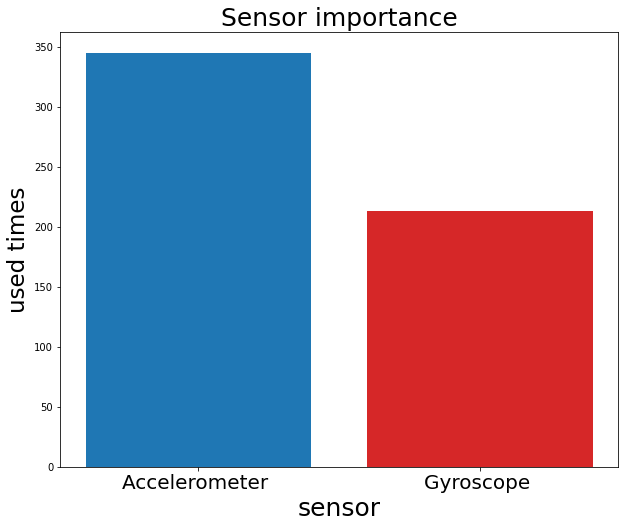

In [ ]:
# Visualizamos la variable que contiene el valor de giroscopio y acelerómetro
Acc=0
Gyro=0
other=0 
for i in train_data.columns:
    if'Acc'in i:
        Acc += 1
    elif'Gyro'in i:
        Gyro += 1
    else:
        other += 1
        
plt.figure(figsize=(10, 8))
plt.bar(x = ['Accelerometer ','Gyroscope '], height = [Acc,Gyro], color=['tab:blue', 'tab:red'])
plt.title("Sensor importance", fontsize = 25)
plt.xlabel("sensor", size=25)
plt.ylabel("used times", size=23)
plt.xticks(fontsize=20)
plt.show()

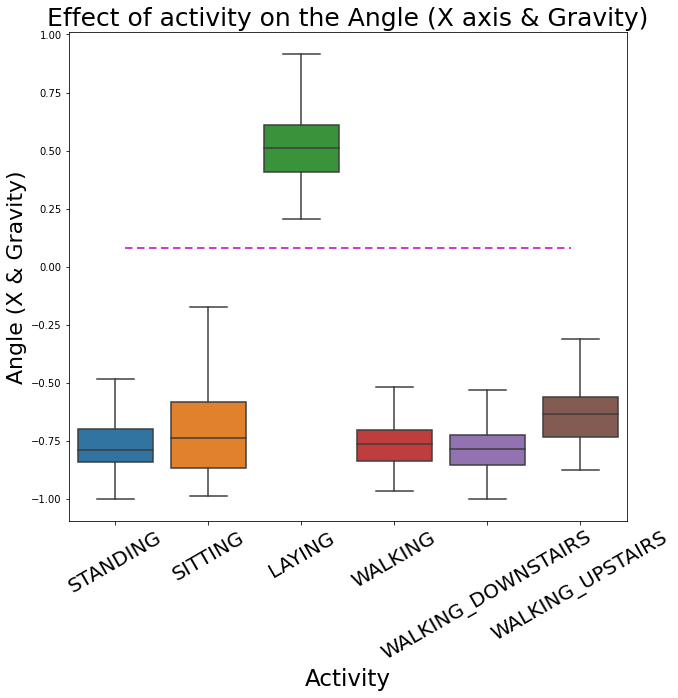

In [ ]:
#Observamos los boxplots de las actividades vs el ángulo (X & Gravity)
plt.figure(figsize=(10,9))
sns.boxplot(x='Activity', y='angle(X,gravityMean)', data=train_data, showfliers=False)
plt.axhline(y=0.08, xmin=0.1, xmax=0.9,c='m',dashes=(5,3))
plt.title('Effect of activity on the Angle (X axis & Gravity)', fontsize=25)
plt.xlabel("Activity", size=23)
plt.ylabel('Angle (X & Gravity)', size=22)
plt.xticks(rotation = 30, fontsize = 20)
plt.show()

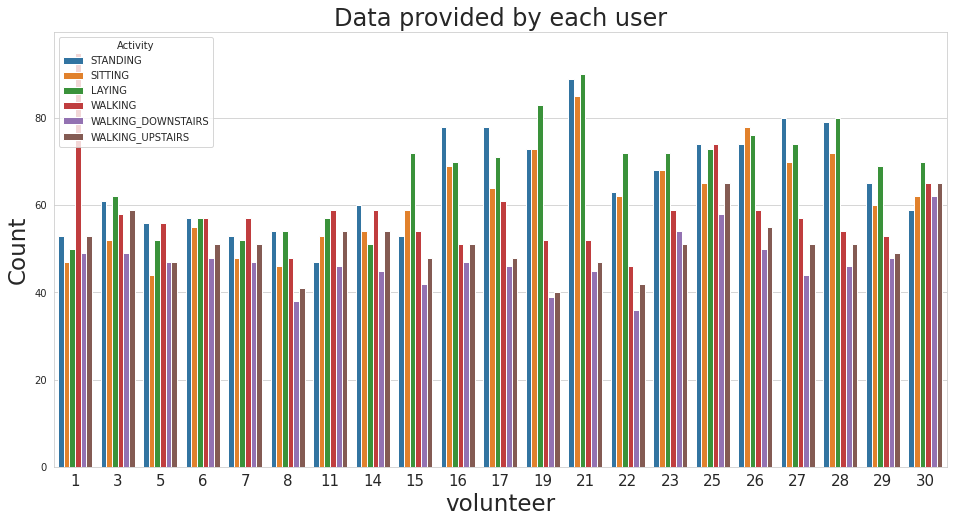

In [ ]:
#Revisamos el número de voluntarios y los datos que pudieron otorgar
sns.set_style('whitegrid')
plt.figure(figsize=(16,8))
sns.color_palette("tab10")
plt.title('Data provided by each user', fontsize=24)
sns.countplot(x='subject',hue='Activity', data = train_data)
plt.xlabel("volunteer", size=23)
plt.ylabel("Count", size=23)
plt.xticks(size=15)
plt.show()

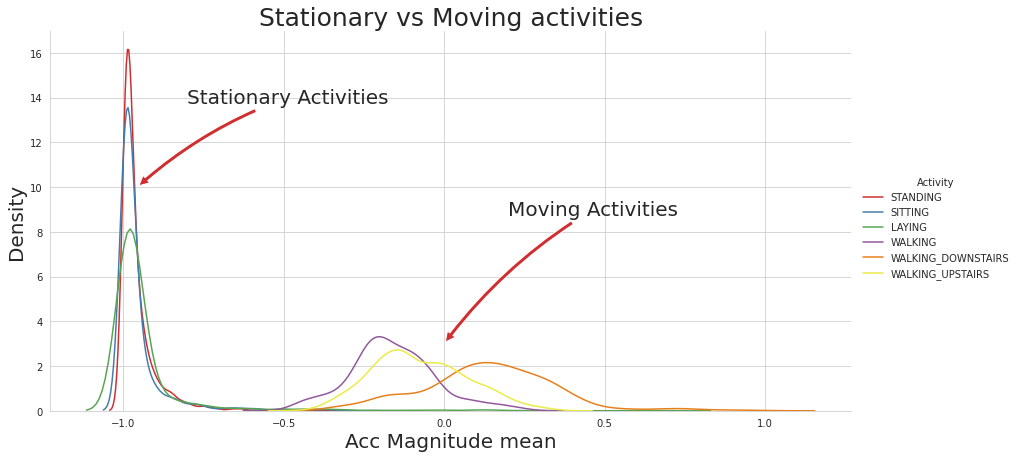

In [ ]:
#Evaluamos las actividades con movimiento y aquellas en donde es casi nulo
sns.set_palette("Set1", desat=0.80)
facetgrid = sns.FacetGrid(train_data, hue='Activity', size=6,aspect=2)
facetgrid.map(sns.distplot,'tBodyAccMag-mean()', hist=False)\
    .add_legend()
plt.annotate("Stationary Activities", xy=(-0.956,10), xytext=(-0.8, 14), size=20,\
            va='center', ha='left',\
            arrowprops=dict(arrowstyle="simple",connectionstyle="arc3,rad=0.1"))

plt.annotate("Moving Activities", xy=(0,3), xytext=(0.2, 9), size=20,\
            va='center', ha='left',\
            arrowprops=dict(arrowstyle="simple",connectionstyle="arc3,rad=0.1"))
plt.title('Stationary vs Moving activities', fontsize=25)
plt.xlabel("Acc Magnitude mean", size=20)
plt.ylabel('Density', size=20)
plt.show()

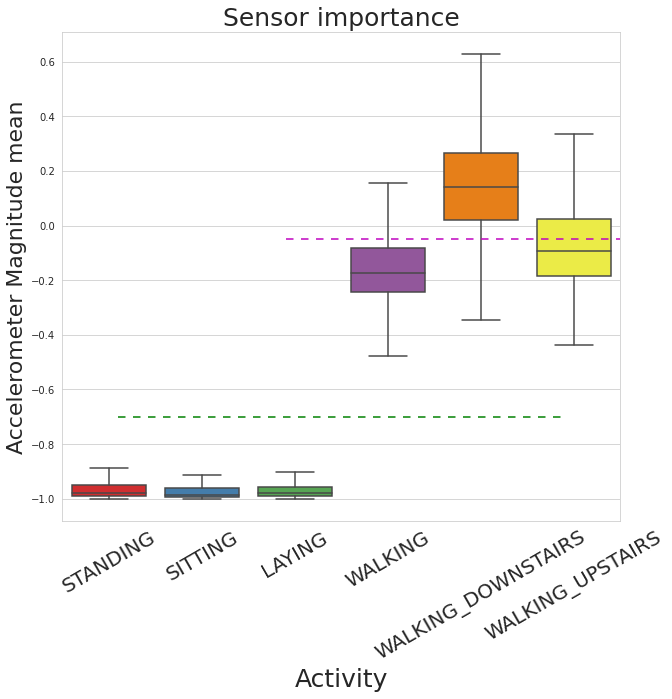

In [ ]:
#Observamos en boxplots las actividades vs la magnitud promedio de su acelerómetro
plt.figure(figsize=(10,9))
sns.boxplot(x='Activity', y='tBodyAccMag-mean()',data=train_data, showfliers=False, saturation=1)
plt.axhline(y=-0.7, xmin=0.1, xmax=0.9,dashes=(5,5), c='g')
plt.axhline(y=-0.05, xmin=0.4, dashes=(5,5), c='m')
plt.title("Sensor importance", fontsize = 25)
plt.xlabel("Activity", size=25)
plt.ylabel('Accelerometer Magnitude mean', size=22)
plt.xticks(rotation=30, fontsize=20)
plt.show()

Observamos que las actividades se dividen notablemente en dos grupos principales.

In [ ]:
#Revisamos la distribución de las actividades
fig = px.pie(train_data, names='Activity',width=980)
fig.update_layout(
    title={
        'text': "Activities distribution in the data",
        'y':0.95,
        'x':0.40,
        'xanchor': 'center',
        'yanchor': 'top'},
         legend_title ="Activities",
         font=dict(
         family="Arial",
         size=18))
fig.show()

In [ ]:
columns = train_data.columns

# Removemos los '()' de los nombres de nuestra columnas en nuestra base train
columns = columns.str.replace('[()]','')
columns = columns.str.replace('[-]', '')
columns = columns.str.replace('[,]','')

train_data.columns = columns
test_data.columns = columns

## T-SNE

La incrustación de vecinos estocástica distribuida (t-SNE) es una técnica no lineal no supervisada utilizada principalmente para la exploración de datos y la visualización de datos de alta dimensión.

En otras palabras, t-SNE te permite visualizar los datos de muchas dimensiones en una forma simplificada.

In [ ]:
def perform_tsne(X_data, y_data, perplexities, n_iter=1000, img_name_prefix='t-sne'):
        
    for index,perplexity in enumerate(perplexities):
        # perform t-sne
        X_reduced = TSNE(verbose=2, perplexity=perplexity).fit_transform(X_data)
        
        # prepare the data for seaborn         
        print('Creating plot for this t-sne visualization..')
        df = pd.DataFrame({'x':X_reduced[:,0], 'y':X_reduced[:,1] ,'label':y_data})
        
        # draw the plot in appropriate place in the grid
        sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,\
                   palette="Set1",markers=['^','v','s','o', '1','2'])
        plt.title("perplexity : {} and max_iter : {}".format(perplexity, n_iter))
        img_name = img_name_prefix + '_perp_{}_iter_{}.png'.format(perplexity, n_iter)
        print('saving this plot as image in present working directory...')
        plt.savefig(img_name)
        plt.show()
        print('Done')

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 7352 samples in 0.004s...
[t-SNE] Computed neighbors for 7352 samples in 1.379s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7352
[t-SNE] Computed conditional probabilities for sample 2000 / 7352
[t-SNE] Computed conditional probabilities for sample 3000 / 7352
[t-SNE] Computed conditional probabilities for sample 4000 / 7352
[t-SNE] Computed conditional probabilities for sample 5000 / 7352
[t-SNE] Computed conditional probabilities for sample 6000 / 7352
[t-SNE] Computed conditional probabilities for sample 7000 / 7352
[t-SNE] Computed conditional probabilities for sample 7352 / 7352
[t-SNE] Mean sigma: 1.274336
[t-SNE] Computed conditional probabilities in 0.199s
[t-SNE] Iteration 50: error = 97.4899445, gradient norm = 0.0198301 (50 iterations in 5.826s)
[t-SNE] Iteration 100: error = 84.0682602, gradient norm = 0.0080147 (50 iterations in 8.370s)
[t-SNE] Iteration 150: error = 82.0161667, gradient norm = 0

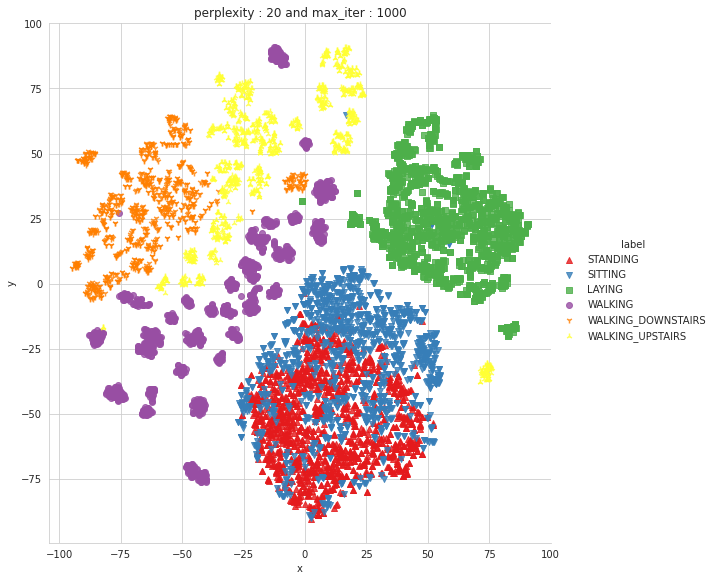

Done


In [ ]:
X_pre_tsne = train_data.drop(['subject', 'Activity'], axis=1)
y_pre_tsne = train_data['Activity']
perform_tsne(X_data = X_pre_tsne,y_data=y_pre_tsne, perplexities =[20])

## PCA

Es un método matemático que se utiliza para reducir el número de variables de forma que pasemos a tener el mínimo número de nuevas variables y que representen a todas las antiguas variables de la forma más representativa posible. Lo anterior se designa al explicar lo más posible la varianza dentro del dataset inicial.

In [ ]:
data = pd.concat([train_data, test_data])
data = train_data.sample(frac=1)
f_df = data.loc[:, data.columns.str.contains('^f|^s|^a|^A')]
t_df = data.loc[:, data.columns.str.contains('^t|^s|^a|^A')]

X = data.drop(['subject', 'Activity'], axis=1)
y = data['Activity']

X_f = f_df.drop(['subject', 'Activity'], axis=1)
y_f = f_df['Activity']

X_t = t_df.drop(['subject', 'Activity'], axis=1)
y_t = t_df['Activity']


pca = PCA(n_components=0.90) #Elegimos que explique el 90% de la varianza de la base Train
pca.fit(X)
x_reduced = pca.transform(X)

print('Frequency components number is {} Time components number is {}'.format(X_f.shape[1], X.shape[1] - X_f.shape[1]))
print('Original number of features {} Reduced number of features {}'.format(X.shape[1], x_reduced.shape[1]))

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
x_train_pca, x_test_pca, y_train_pca, y_test_pca = train_test_split(x_reduced, y, test_size=0.2, shuffle=True, random_state=42)
x_train_f, x_test_f, y_train_f, y_test_f = train_test_split(X_f, y_f, test_size=0.2, shuffle=True, random_state=42)
x_train_t, x_test_t, y_train_t, y_test_t = train_test_split(X_t, y_t, test_size=0.2, shuffle=True, random_state=42)

Frequency components number is 296 Time components number is 265
Original number of features 561 Reduced number of features 34


Podemos observar que el PCA reduce nuestras variables iniciales de 561 a solo 34, estas últimas 34 explican el 90% de información del dataset.

## Modelo

In [ ]:
#Construimos una función que nos permitar evaluar como es el perfomance de nuestro modelo.
kernal_evals = dict()
def evaluate_classification(model, name, X_train, X_test, y_train, y_test):
    train_accuracy = metrics.accuracy_score(y_train, model.predict(X_train))
    test_accuracy = metrics.accuracy_score(y_test, model.predict(X_test))
    
    train_precision = metrics.precision_score(y_train, model.predict(X_train), average='micro')
    test_precision = metrics.precision_score(y_test, model.predict(X_test), average='micro')
    
    train_recall = metrics.recall_score(y_train, model.predict(X_train), average='micro')
    test_recall = metrics.recall_score(y_test, model.predict(X_test), average='micro')
    
    kernal_evals[str(name)] = [train_accuracy, test_accuracy, train_precision, test_precision, train_recall, test_recall]
    print("Training Accuracy " + str(name) + " {}  Test Accuracy ".format(train_accuracy*100) + str(name) + " {}".format(test_accuracy*100))
    print("Training Precision " + str(name) + " {}  Test Precision ".format(train_precision*100) + str(name) + " {}".format(test_precision*100))
    print("Training Recall " + str(name) + " {}  Test Recall ".format(train_recall*100) + str(name) + " {}".format(test_recall*100))
    
    actual = y_test
    predicted = model.predict(X_test)
    confusion_matrix = metrics.confusion_matrix(actual, predicted)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['LAYING', 'SITTING', 'STANDING', 'WALKING', 'DOWNSTAIRS',
       'UPSTAIRS'])

    fig, ax = plt.subplots(figsize=(10,10))
    ax.grid(False)
    cm_display.plot(ax=ax)

## Support vector machine (Linear)

Support vector machine (SVM) es un algoritmo de aprendizaje supervisado que se utiliza en muchos problemas de clasificación y regresión, incluidas aplicaciones médicas de procesamiento de señales, procesamiento del lenguaje natural y reconocimiento de imágenes y voz.

El objetivo del algoritmo SVM es encontrar un hiperplano que separe de la mejor forma posible dos clases diferentes de puntos de datos. “De la mejor forma posible” implica el hiperplano con el margen más amplio entre las dos clases, representado por los signos más y menos en la siguiente figura. El margen se define como la anchura máxima de la región paralela al hiperplano que no tiene puntos de datos interiores. El algoritmo solo puede encontrar este hiperplano en problemas que permiten separación lineal; en la mayoría de los problemas prácticos, el algoritmo maximiza el margen flexible permitiendo un pequeño número de clasificaciones erróneas.

Training Accuracy Linear SVC(LBasedImpl) 99.60891004931133  Test Accuracy Linear SVC(LBasedImpl) 98.43643779741672
Training Precision Linear SVC(LBasedImpl) 99.60891004931133  Test Precision Linear SVC(LBasedImpl) 98.43643779741672
Training Recall Linear SVC(LBasedImpl) 99.60891004931133  Test Recall Linear SVC(LBasedImpl) 98.43643779741672


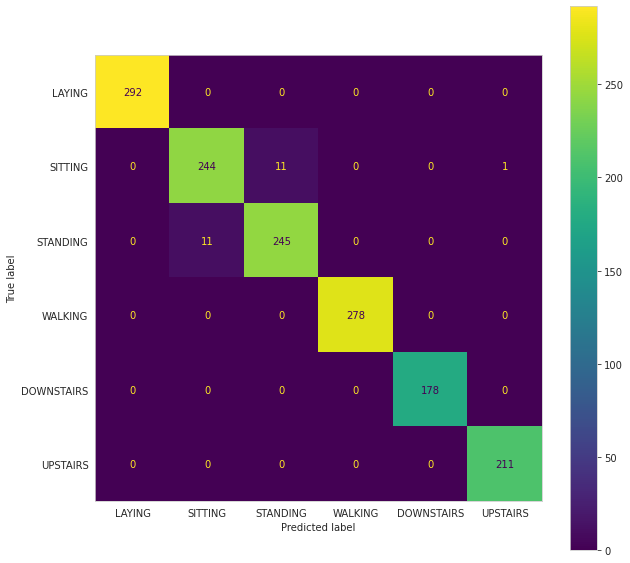

In [ ]:
#Entrenamos modelo
lin_svc = svm.LinearSVC().fit(x_train, y_train)
#Utilizamos la función que nos permitirá saber que tan bueno es el modelo y además podremos visualizar las predicciones que tiene.
evaluate_classification(lin_svc, "Linear SVC(LBasedImpl)", x_train, x_test, y_train, y_test)

## Feature reduction with PCA

Training Accuracy Linear SVC(PCA) 94.43972113586125  Test Accuracy Linear SVC(PCA) 93.60978925900748
Training Precision Linear SVC(PCA) 94.43972113586125  Test Precision Linear SVC(PCA) 93.60978925900748
Training Recall Linear SVC(PCA) 94.43972113586125  Test Recall Linear SVC(PCA) 93.60978925900748


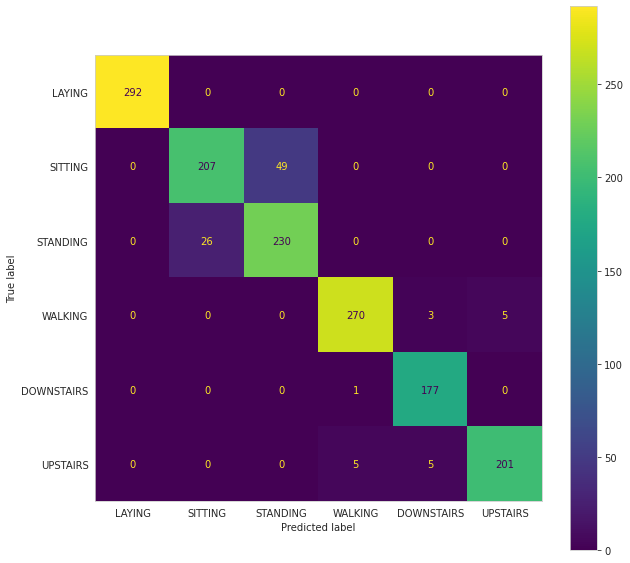

In [ ]:
#En este caso, haremos el mismo modelo pero con el dataset de 155 variables que el PCA nos dio.
lin_svc_pca = svm.LinearSVC().fit(x_train_pca, y_train_pca)
evaluate_classification(lin_svc_pca, "Linear SVC(PCA)", x_train_pca, x_test_pca, y_train_pca, y_test_pca)

In [ ]:
#Pegamos predicciones a base inicial
y_preds = lin_svc_pca.predict(x_test_pca)

df_finale=x_test
df_finale['Prediction'] = y_preds

In [ ]:
df_finale.head()

,tBodyAccmeanX,tBodyAccmeanY,tBodyAccmeanZ,tBodyAccstdX,tBodyAccstdY,tBodyAccstdZ,tBodyAccmadX,tBodyAccmadY,tBodyAccmadZ,tBodyAccmaxX,tBodyAccmaxY,tBodyAccmaxZ,tBodyAccminX,tBodyAccminY,tBodyAccminZ,tBodyAccsma,tBodyAccenergyX,tBodyAccenergyY,tBodyAccenergyZ,tBodyAcciqrX,tBodyAcciqrY,tBodyAcciqrZ,tBodyAccentropyX,tBodyAccentropyY,tBodyAccentropyZ,tBodyAccarCoeffX1,tBodyAccarCoeffX2,tBodyAccarCoeffX3,tBodyAccarCoeffX4,tBodyAccarCoeffY1,tBodyAccarCoeffY2,tBodyAccarCoeffY3,tBodyAccarCoeffY4,tBodyAccarCoeffZ1,tBodyAccarCoeffZ2,tBodyAccarCoeffZ3,tBodyAccarCoeffZ4,tBodyAcccorrelationXY,tBodyAcccorrelationXZ,tBodyAcccorrelationYZ,tGravityAccmeanX,tGravityAccmeanY,tGravityAccmeanZ,tGravityAccstdX,tGravityAccstdY,tGravityAccstdZ,tGravityAccmadX,tGravityAccmadY,tGravityAccmadZ,tGravityAccmaxX,tGravityAccmaxY,tGravityAccmaxZ,tGravityAccminX,tGravityAccminY,tGravityAccminZ,tGravityAccsma,tGravityAccenergyX,tGravityAccenergyY,tGravityAccenergyZ,tGravityAcciqrX,tGravityAcciqrY,tGravityAcciqrZ,tGravityAccentropyX,tGravityAccentropyY,tGravityAccentropyZ,tGravityAccarCoeffX1,tGravityAccarCoeffX2,tGravityAccarCoeffX3,tGravityAccarCoeffX4,tGravityAccarCoeffY1,tGravityAccarCoeffY2,tGravityAccarCoeffY3,tGravityAccarCoeffY4,tGravityAccarCoeffZ1,tGravityAccarCoeffZ2,tGravityAccarCoeffZ3,tGravityAccarCoeffZ4,tGravityAcccorrelationXY,tGravityAcccorrelationXZ,tGravityAcccorrelationYZ,tBodyAccJerkmeanX,tBodyAccJerkmeanY,tBodyAccJerkmeanZ,tBodyAccJerkstdX,tBodyAccJerkstdY,tBodyAccJerkstdZ,tBodyAccJerkmadX,tBodyAccJerkmadY,tBodyAccJerkmadZ,tBodyAccJerkmaxX,tBodyAccJerkmaxY,tBodyAccJerkmaxZ,tBodyAccJerkminX,tBodyAccJerkminY,tBodyAccJerkminZ,tBodyAccJerksma,tBodyAccJerkenergyX,tBodyAccJerkenergyY,tBodyAccJerkenergyZ,tBodyAccJerkiqrX,tBodyAccJerkiqrY,tBodyAccJerkiqrZ,tBodyAccJerkentropyX,tBodyAccJerkentropyY,tBodyAccJerkentropyZ,tBodyAccJerkarCoeffX1,tBodyAccJerkarCoeffX2,tBodyAccJerkarCoeffX3,tBodyAccJerkarCoeffX4,tBodyAccJerkarCoeffY1,tBodyAccJerkarCoeffY2,tBodyAccJerkarCoeffY3,tBodyAccJerkarCoeffY4,tBodyAccJerkarCoeffZ1,tBodyAccJerkarCoeffZ2,tBodyAccJerkarCoeffZ3,tBodyAccJerkarCoeffZ4,tBodyAccJerkcorrelationXY,tBodyAccJerkcorrelationXZ,tBodyAccJerkcorrelationYZ,tBodyGyromeanX,tBodyGyromeanY,tBodyGyromeanZ,tBodyGyrostdX,tBodyGyrostdY,tBodyGyrostdZ,tBodyGyromadX,tBodyGyromadY,tBodyGyromadZ,tBodyGyromaxX,tBodyGyromaxY,tBodyGyromaxZ,tBodyGyrominX,tBodyGyrominY,tBodyGyrominZ,tBodyGyrosma,tBodyGyroenergyX,tBodyGyroenergyY,tBodyGyroenergyZ,tBodyGyroiqrX,tBodyGyroiqrY,tBodyGyroiqrZ,tBodyGyroentropyX,tBodyGyroentropyY,tBodyGyroentropyZ,tBodyGyroarCoeffX1,tBodyGyroarCoeffX2,tBodyGyroarCoeffX3,tBodyGyroarCoeffX4,tBodyGyroarCoeffY1,tBodyGyroarCoeffY2,tBodyGyroarCoeffY3,tBodyGyroarCoeffY4,tBodyGyroarCoeffZ1,tBodyGyroarCoeffZ2,tBodyGyroarCoeffZ3,tBodyGyroarCoeffZ4,tBodyGyrocorrelationXY,tBodyGyrocorrelationXZ,tBodyGyrocorrelationYZ,tBodyGyroJerkmeanX,tBodyGyroJerkmeanY,tBodyGyroJerkmeanZ,tBodyGyroJerkstdX,tBodyGyroJerkstdY,tBodyGyroJerkstdZ,tBodyGyroJerkmadX,tBodyGyroJerkmadY,tBodyGyroJerkmadZ,tBodyGyroJerkmaxX,tBodyGyroJerkmaxY,tBodyGyroJerkmaxZ,tBodyGyroJerkminX,tBodyGyroJerkminY,tBodyGyroJerkminZ,tBodyGyroJerksma,tBodyGyroJerkenergyX,tBodyGyroJerkenergyY,tBodyGyroJerkenergyZ,tBodyGyroJerkiqrX,tBodyGyroJerkiqrY,tBodyGyroJerkiqrZ,tBodyGyroJerkentropyX,tBodyGyroJerkentropyY,tBodyGyroJerkentropyZ,tBodyGyroJerkarCoeffX1,tBodyGyroJerkarCoeffX2,tBodyGyroJerkarCoeffX3,tBodyGyroJerkarCoeffX4,tBodyGyroJerkarCoeffY1,tBodyGyroJerkarCoeffY2,tBodyGyroJerkarCoeffY3,tBodyGyroJerkarCoeffY4,tBodyGyroJerkarCoeffZ1,tBodyGyroJerkarCoeffZ2,tBodyGyroJerkarCoeffZ3,tBodyGyroJerkarCoeffZ4,tBodyGyroJerkcorrelationXY,tBodyGyroJerkcorrelationXZ,tBodyGyroJerkcorrelationYZ,tBodyAccMagmean,tBodyAccMagstd,tBodyAccMagmad,tBodyAccMagmax,tBodyAccMagmin,tBodyAccMagsma,tBodyAccMagenergy,tBodyAccMagiqr,tBodyAccMagentropy,tBodyAccMagarCoeff1,tBodyAccMagarCoeff2,tBodyAccMagarCoeff3,tBodyAccMagarCoeff4,tGravityAccMagmean,tGravityAccMagstd,tGravityAccMagmad,tGravityAccMagmax,tGravityAccMagmin,tGravityAccMags

In [ ]:
#Ahora, creamos ID ficticio para poder realizar un join con esta que contiene el resultado del modelo y la tabla de los clientes que la marca de que al menos realizan una transacción de gastos medicos
df_finale = df_finale.reset_index()
df_finale = df_finale.rename(columns={"index":"New_ID"})
df_finale['New_ID'] = df_finale.index

In [ ]:
#Realizamos INNER join de la base Test con los datos de clientes construida.
df_finale2=pd.merge(ctes_transgiro_data,df_finale,on='New_ID')

In [ ]:
df_finale2.head(5)

,New_ID,NU_CTE_COD,EDAD,CD_ESTADO,CD_POSTAL,CD_SEXO,GM3,tBodyAccmeanX,tBodyAccmeanY,tBodyAccmeanZ,tBodyAccstdX,tBodyAccstdY,tBodyAccstdZ,tBodyAccmadX,tBodyAccmadY,tBodyAccmadZ,tBodyAccmaxX,tBodyAccmaxY,tBodyAccmaxZ,tBodyAccminX,tBodyAccminY,tBodyAccminZ,tBodyAccsma,tBodyAccenergyX,tBodyAccenergyY,tBodyAccenergyZ,tBodyAcciqrX,tBodyAcciqrY,tBodyAcciqrZ,tBodyAccentropyX,tBodyAccentropyY,tBodyAccentropyZ,tBodyAccarCoeffX1,tBodyAccarCoeffX2,tBodyAccarCoeffX3,tBodyAccarCoeffX4,tBodyAccarCoeffY1,tBodyAccarCoeffY2,tBodyAccarCoeffY3,tBodyAccarCoeffY4,tBodyAccarCoeffZ1,tBodyAccarCoeffZ2,tBodyAccarCoeffZ3,tBodyAccarCoeffZ4,tBodyAcccorrelationXY,tBodyAcccorrelationXZ,tBodyAcccorrelationYZ,tGravityAccmeanX,tGravityAccmeanY,tGravityAccmeanZ,tGravityAccstdX,tGravityAccstdY,tGravityAccstdZ,tGravityAccmadX,tGravityAccmadY,tGravityAccmadZ,tGravityAccmaxX,tGravityAccmaxY,tGravityAccmaxZ,tGravityAccminX,tGravityAccminY,tGravityAccminZ,tGravityAccsma,tGravityAccenergyX,tGravityAccenergyY,tGravityAccenergyZ,tGravityAcciqrX,tGravityAcciqrY,tGravityAcciqrZ,tGravityAccentropyX,tGravityAccentropyY,tGravityAccentropyZ,tGravityAccarCoeffX1,tGravityAccarCoeffX2,tGravityAccarCoeffX3,tGravityAccarCoeffX4,tGravityAccarCoeffY1,tGravityAccarCoeffY2,tGravityAccarCoeffY3,tGravityAccarCoeffY4,tGravityAccarCoeffZ1,tGravityAccarCoeffZ2,tGravityAccarCoeffZ3,tGravityAccarCoeffZ4,tGravityAcccorrelationXY,tGravityAcccorrelationXZ,tGravityAcccorrelationYZ,tBodyAccJerkmeanX,tBodyAccJerkmeanY,tBodyAccJerkmeanZ,tBodyAccJerkstdX,tBodyAccJerkstdY,tBodyAccJerkstdZ,tBodyAccJerkmadX,tBodyAccJerkmadY,tBodyAccJerkmadZ,tBodyAccJerkmaxX,tBodyAccJerkmaxY,tBodyAccJerkmaxZ,tBodyAccJerkminX,tBodyAccJerkminY,tBodyAccJerkminZ,tBodyAccJerksma,tBodyAccJerkenergyX,tBodyAccJerkenergyY,tBodyAccJerkenergyZ,tBodyAccJerkiqrX,tBodyAccJerkiqrY,tBodyAccJerkiqrZ,tBodyAccJerkentropyX,tBodyAccJerkentropyY,tBodyAccJerkentropyZ,tBodyAccJerkarCoeffX1,tBodyAccJerkarCoeffX2,tBodyAccJerkarCoeffX3,tBodyAccJerkarCoeffX4,tBodyAccJerkarCoeffY1,tBodyAccJerkarCoeffY2,tBodyAccJerkarCoeffY3,tBodyAccJerkarCoeffY4,tBodyAccJerkarCoeffZ1,tBodyAccJerkarCoeffZ2,tBodyAccJerkarCoeffZ3,tBodyAccJerkarCoeffZ4,tBodyAccJerkcorrelationXY,tBodyAccJerkcorrelationXZ,tBodyAccJerkcorrelationYZ,tBodyGyromeanX,tBodyGyromeanY,tBodyGyromeanZ,tBodyGyrostdX,tBodyGyrostdY,tBodyGyrostdZ,tBodyGyromadX,tBodyGyromadY,tBodyGyromadZ,tBodyGyromaxX,tBodyGyromaxY,tBodyGyromaxZ,tBodyGyrominX,tBodyGyrominY,tBodyGyrominZ,tBodyGyrosma,tBodyGyroenergyX,tBodyGyroenergyY,tBodyGyroenergyZ,tBodyGyroiqrX,tBodyGyroiqrY,tBodyGyroiqrZ,tBodyGyroentropyX,tBodyGyroentropyY,tBodyGyroentropyZ,tBodyGyroarCoeffX1,tBodyGyroarCoeffX2,tBodyGyroarCoeffX3,tBodyGyroarCoeffX4,tBodyGyroarCoeffY1,tBodyGyroarCoeffY2,tBodyGyroarCoeffY3,tBodyGyroarCoeffY4,tBodyGyroarCoeffZ1,tBodyGyroarCoeffZ2,tBodyGyroarCoeffZ3,tBodyGyroarCoeffZ4,tBodyGyrocorrelationXY,tBodyGyrocorrelationXZ,tBodyGyrocorrelationYZ,tBodyGyroJerkmeanX,tBodyGyroJerkmeanY,tBodyGyroJerkmeanZ,tBodyGyroJerkstdX,tBodyGyroJerkstdY,tBodyGyroJerkstdZ,tBodyGyroJerkmadX,tBodyGyroJerkmadY,tBodyGyroJerkmadZ,tBodyGyroJerkmaxX,tBodyGyroJerkmaxY,tBodyGyroJerkmaxZ,tBodyGyroJerkminX,tBodyGyroJerkminY,tBodyGyroJerkminZ,tBodyGyroJerksma,tBodyGyroJerkenergyX,tBodyGyroJerkenergyY,tBodyGyroJerkenergyZ,tBodyGyroJerkiqrX,tBodyGyroJerkiqrY,tBodyGyroJerkiqrZ,tBodyGyroJerkentropyX,tBodyGyroJerkentropyY,tBodyGyroJerkentropyZ,tBodyGyroJerkarCoeffX1,tBodyGyroJerkarCoeffX2,tBodyGyroJerkarCoeffX3,tBodyGyroJerkarCoeffX4,tBodyGyroJerkarCoeffY1,tBodyGyroJerkarCoeffY2,tBodyGyroJerkarCoeffY3,tBodyGyroJerkarCoeffY4,tBodyGyroJerkarCoeffZ1,tBodyGyroJerkarCoeffZ2,tBodyGyroJerkarCoeffZ3,tBodyGyroJerkarCoeffZ4,tBodyGyroJerkcorrelationXY,tBodyGyroJerkcorrelationXZ,tBodyGyroJerkcorrelationYZ,tBodyAccMagmean,tBodyAccMagstd,tBodyAccMagmad,tBodyAccMagmax,tBodyAccMagmin,tBodyAccMagsma,tBodyAccMagenergy,tBodyAccMagiqr,tBodyAccMagentropy,tBodyAccMagarCoeff1,tBodyAccMagarCoeff2,tBodyAccMagarCoeff3,tBodyAccMagarCoeff4,tGravityAccMagmean,tGravityAccMagstd,tGravityAccMag

# Construcción Buyer Persons

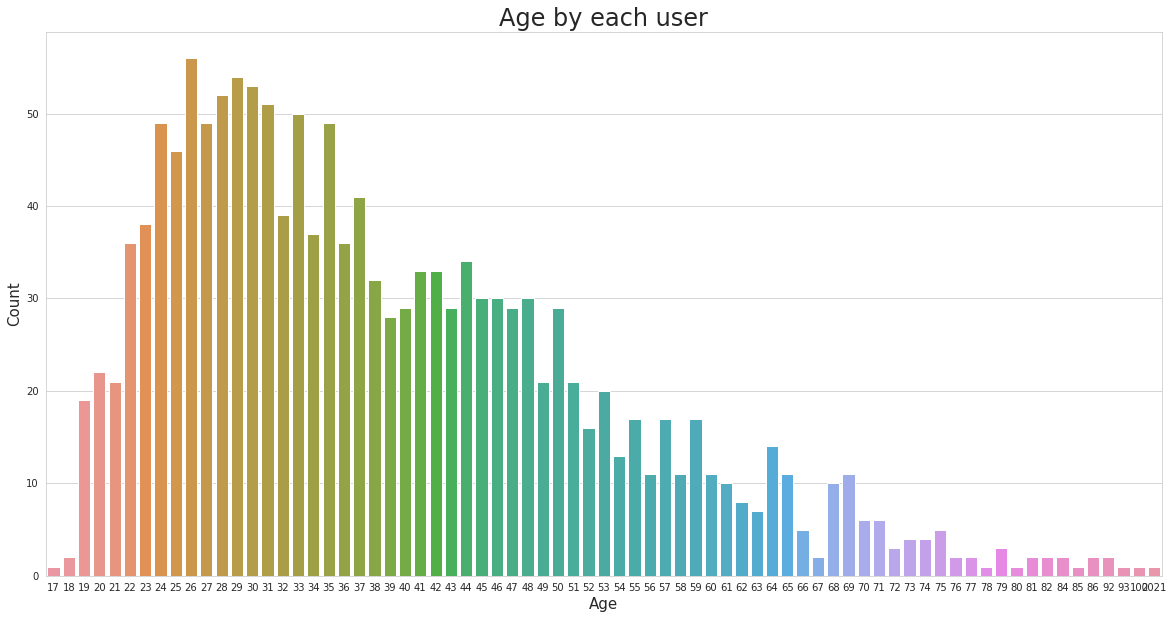

In [ ]:
# Revisamos distribución de la edad
sns.set_style('whitegrid')
plt.figure(figsize=(20,10))
sns.color_palette("tab10")
plt.title('Age by each user', fontsize=24)
sns.countplot(x='EDAD', data = df_finale2)
plt.xlabel("Age", size=15)
plt.ylabel("Count", size=15)
plt.xticks(size=10)
plt.show()

In [ ]:
#Observamos la distribución de los grupos de predicción
fig = px.pie(df_finale2, names='Prediction',width=800)
fig.update_layout(
    title={
        'text': "Prediction distribution in the data",
        'y':0.95,
        'x':0.40,
        'xanchor': 'center',
        'yanchor': 'top'},
         legend_title ="Prediction",
         font=dict(
         family="Arial",
         size=18))
fig.show()

In [ ]:
# Construimos primer filtro del Buyer Person, que son los grupos de Inactivos y Activos
df_finale2.loc[df_finale2['Prediction'].isin(['LAYING','SITTING','STANDING']), 'Group1'] = 'Inactivo' 
df_finale2.loc[df_finale2['Prediction'].isin(['WALKING','WALKING_DOWNSTAIRS','WALKING_UPSTAIRS']), 'Group1'] = 'Activo' 

#Vemos su distribución en la visualización
fig = px.pie(df_finale2, names='Group1',width=500)
fig.update_layout(
    title={
        'text': "Group1 distribution in the data",
        'y':0.95,
        'x':0.40,
        'xanchor': 'center',
        'yanchor': 'top'},
         legend_title ="Group1",
         font=dict(
         family="Arial",
         size=18))
fig.show()

In [ ]:
#Construimos el segundo filtro del Buyer Person que es identificar si son mayores de edad o no
df_finale2.loc[df_finale2['EDAD']<60, 'Group2'] = 'NO_tercera_edad' 
df_finale2.loc[df_finale2['EDAD']>=60, 'Group2'] = 'Tercera_edad' 

fig = px.pie(df_finale2, names='Group2',width=500)
fig.update_layout(
    title={
        'text': "Group2 distribution in the data",
        'y':0.95,
        'x':0.40,
        'xanchor': 'center',
        'yanchor': 'top'},
         legend_title ="Group2",
         font=dict(
         family="Arial",
         size=18))
fig.show()

In [ ]:
#Construimos el tercer filtro del Buyer Person que es identificar si realizaron o no más de 3 transacciones en Gastos Médicos
#Y esto nos llevaría a sospechar que es un cliente con alguna necesidad médica o en su caso, discapacidad.
df_finale2.loc[df_finale2['GM3']==1, 'Group3'] = 'Gasto_Medico' 
df_finale2.loc[df_finale2['GM3']==0, 'Group3'] = 'NO_Gasto_Medico' 

fig = px.pie(df_finale2, names='Group3',width=500)
fig.update_layout(
    title={
        'text': "Group3 distribution in the data",
        'y':0.95,
        'x':0.40,
        'xanchor': 'center',
        'yanchor': 'top'},
         legend_title ="Group2",
         font=dict(
         family="Arial",
         size=18))
fig.show()

In [ ]:
#Construimos grupos finales
df_finale2.loc[(df_finale2['Group1']=='Activo') & (df_finale2['Group2']=='Tercera_edad') & (df_finale2['Group3']=='Gasto_Medico'), 'Buyer_Person'] = df_finale2[['Group1', 'Group2','Group3']].agg('/'.join, axis=1)
df_finale2.loc[(df_finale2['Group1']=='Inactivo')  & (df_finale2['Group2']=='Tercera_edad') & (df_finale2['Group3']=='Gasto_Medico'), 'Buyer_Person'] = df_finale2[['Group1', 'Group2','Group3']].agg('/'.join, axis=1)
df_finale2.loc[(df_finale2['Group1']=='Activo') & (df_finale2['Group2']=='NO_tercera_edad') & (df_finale2['Group3']=='Gasto_Medico'), 'Buyer_Person'] = df_finale2[['Group1', 'Group2','Group3']].agg('/'.join, axis=1)
df_finale2.loc[(df_finale2['Group1']=='Inactivo')  & (df_finale2['Group2']=='NO_tercera_edad') & (df_finale2['Group3']=='Gasto_Medico'), 'Buyer_Person'] = df_finale2[['Group1', 'Group2','Group3']].agg('/'.join, axis=1)


df_finale2.loc[(df_finale2['Group1']=='Activo') & (df_finale2['Group2']=='Tercera_edad') & (df_finale2['Group3']=='NO_Gasto_Medico'), 'Buyer_Person'] = df_finale2[['Group1', 'Group2','Group3']].agg('/'.join, axis=1)
df_finale2.loc[(df_finale2['Group1']=='Inactivo')  & (df_finale2['Group2']=='Tercera_edad') & (df_finale2['Group3']=='NO_Gasto_Medico'), 'Buyer_Person'] = df_finale2[['Group1', 'Group2','Group3']].agg('/'.join, axis=1)
df_finale2.loc[(df_finale2['Group1']=='Activo') & (df_finale2['Group2']=='NO_tercera_edad') & (df_finale2['Group3']=='NO_Gasto_Medico'), 'Buyer_Person'] = df_finale2[['Group1', 'Group2','Group3']].agg('/'.join, axis=1)
df_finale2.loc[(df_finale2['Group1']=='Inactivo')  & (df_finale2['Group2']=='NO_tercera_edad') & (df_finale2['Group3']=='NO_Gasto_Medico'), 'Buyer_Person'] = df_finale2[['Group1', 'Group2','Group3']].agg('/'.join, axis=1)


In [ ]:
#Visualizamos distribución de Buyer Person
fig = px.pie(df_finale2, names='Buyer_Person',width=800)
fig.update_layout(
    title={
        'text': "Buyer_Person distribution in the data",
        'y':0.95,
        'x':0.40,
        'xanchor': 'center',
        'yanchor': 'top'},
         legend_title ="Buyer_Person",
         font=dict(
         family="Arial",
         size=18))
fig.show()

In [ ]:
#Buyer Person finales
df_finale2['Buyer_Person'].value_counts()

Inactivo/NO_tercera_edad/NO_Gasto_Medico    506
Activo/NO_tercera_edad/NO_Gasto_Medico      410
Inactivo/NO_tercera_edad/Gasto_Medico       228
Activo/NO_tercera_edad/Gasto_Medico         187
Activo/Tercera_edad/NO_Gasto_Medico          46
Inactivo/Tercera_edad/NO_Gasto_Medico        45
Inactivo/Tercera_edad/Gasto_Medico           25
Activo/Tercera_edad/Gasto_Medico             24
Name: Buyer_Person, dtype: int64

In [ ]:
#Calculamos tiempo final de ejecución
fin = time.time()
print(fin-inicio) 

#133.81912183761597 segundos

#1378.2226061820984

236.8967788219452
